In [2]:
!pip install pandas matplotlib prophet --quiet

18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Best params: cps=0.5, sps=10, MAE=0.2402


  0%|          | 0/3 [00:00<?, ?it/s]

18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon       mae      mape
0  7 days  0.388569  0.038017
1  8 days  0.349498  0.034016
2 10 days  0.347686  0.033440
3 11 days  0.412371  0.038229
4 12 days  0.443028  0.040203


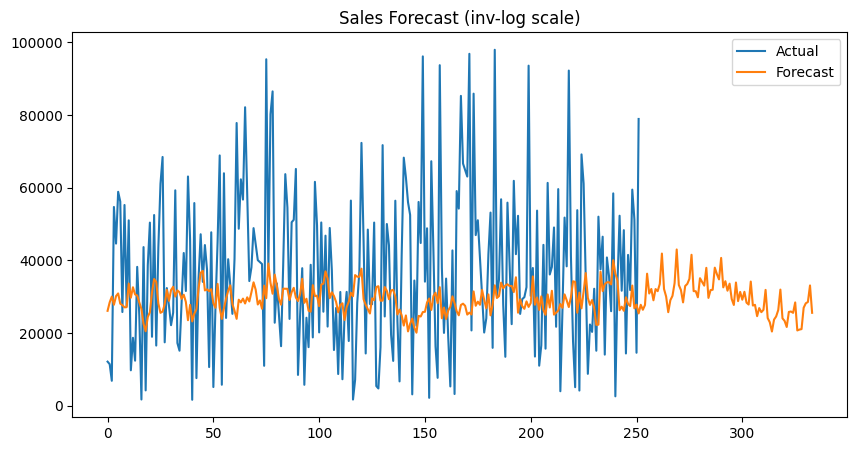

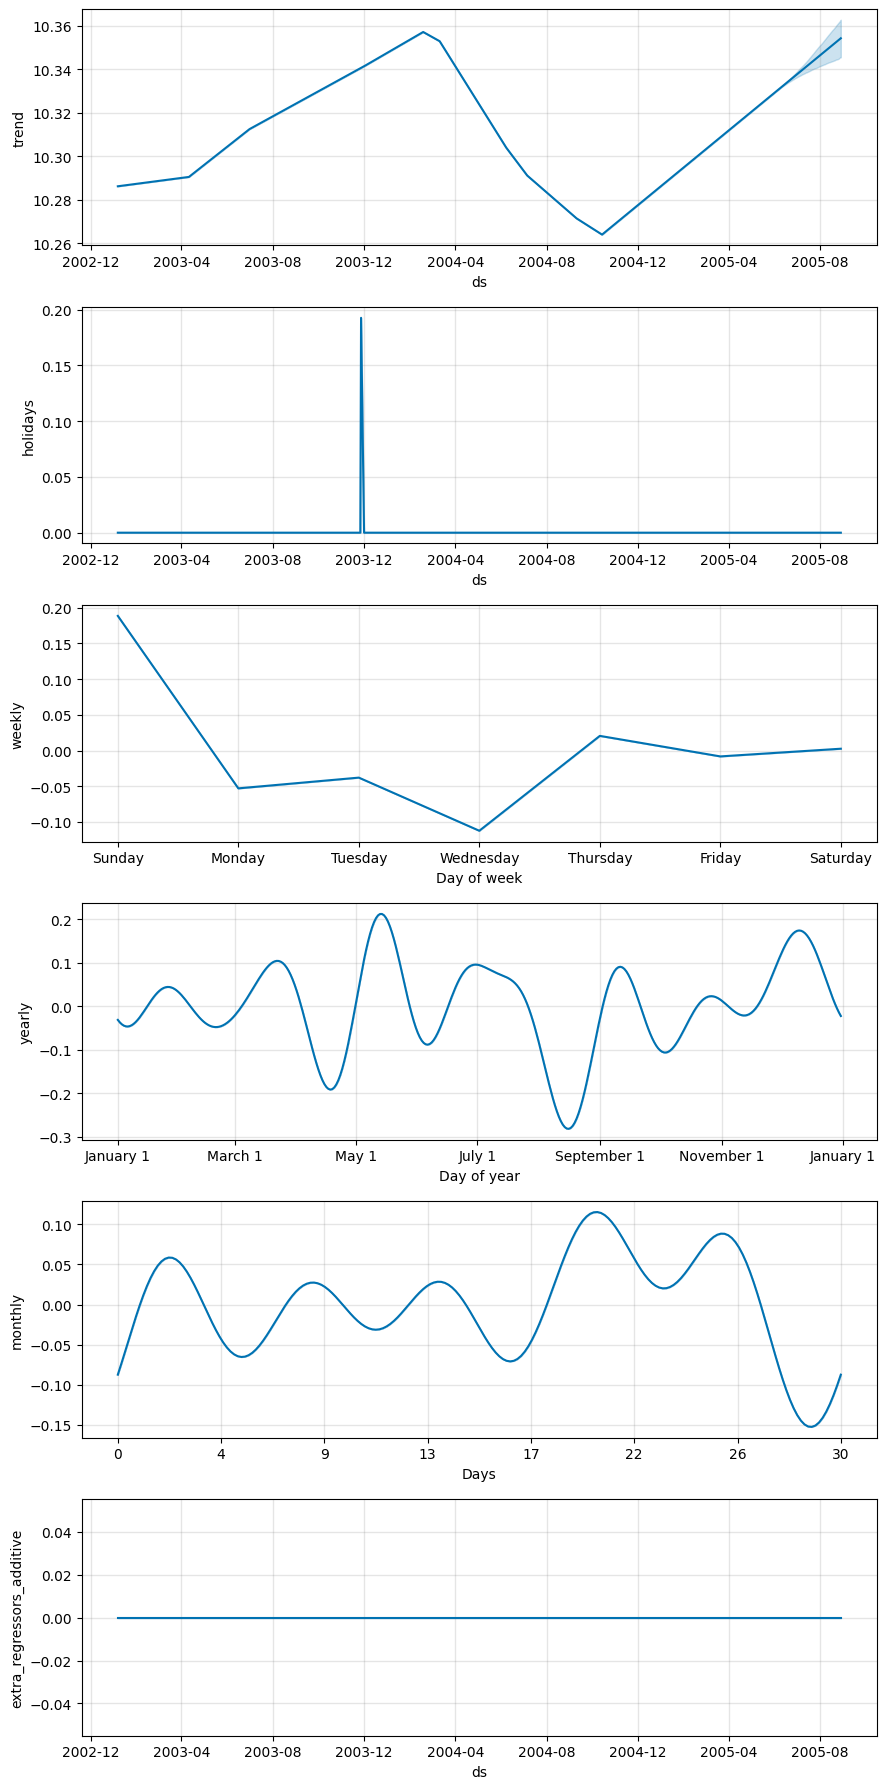

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

df = pd.read_csv("sales_data_sample.csv", encoding='ISO-8859-1')
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

daily = df.groupby('ORDERDATE').agg({
    'SALES': 'sum',
    'QUANTITYORDERED': 'sum',
    'PRICEEACH': 'mean'
}).reset_index().rename(columns={'ORDERDATE':'ds','SALES':'y'})

Q1, Q3 = daily['y'].quantile([0.25, 0.75])
mask = daily['y'].between(Q1 - 1.5 * (Q3 - Q1), Q3 + 1.5 * (Q3 - Q1))
daily = daily.loc[mask]

daily['y'] = np.log1p(daily['y'])

promo_dates = pd.DataFrame({
    'holiday': 'promo',
    'ds': pd.to_datetime(['2003-11-27', '2003-12-25']),
    'lower_window': 0,
    'upper_window': 1
})

param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [5, 10]
}

best_score = np.inf
best_params = None

for cps in param_grid['changepoint_prior_scale']:
    for sps in param_grid['seasonality_prior_scale']:
        m = Prophet(
            holidays=promo_dates,
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps
        )
        m.add_regressor('QUANTITYORDERED')
        m.add_regressor('PRICEEACH')
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        m.add_seasonality(name='weekly', period=7, fourier_order=3)
        m.fit(daily[['ds', 'y', 'QUANTITYORDERED', 'PRICEEACH']])

        train = daily.iloc[:-30]
        test  = daily.iloc[-30:]
        forecast = m.predict(test[['ds', 'QUANTITYORDERED', 'PRICEEACH']])
        mae = mean_absolute_error(test['y'], forecast['yhat'])

        if mae < best_score:
            best_score = mae
            best_params = (cps, sps)

print(f"Best params: cps={best_params[0]}, sps={best_params[1]}, MAE={best_score:.4f}")

m = Prophet(
    holidays=promo_dates,
    changepoint_prior_scale=best_params[0],
    seasonality_prior_scale=best_params[1]
)
m.add_regressor('QUANTITYORDERED')
m.add_regressor('PRICEEACH')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.fit(daily[['ds', 'y', 'QUANTITYORDERED', 'PRICEEACH']])

df_cv = cross_validation(m, initial='365 days', period='180 days', horizon='60 days')
perf = performance_metrics(df_cv)
print(perf[['horizon', 'mae', 'mape']].head())

future = m.make_future_dataframe(periods=90)
future['QUANTITYORDERED'] = daily['QUANTITYORDERED'].mean()
future['PRICEEACH']      = daily['PRICEEACH'].mean()

forecast = m.predict(future)
forecast['yhat_inv'] = np.expm1(forecast['yhat'])

plt.figure(figsize=(10, 5))
plt.plot(np.expm1(daily['y']), label='Actual')
plt.plot(forecast['yhat_inv'],  label='Forecast')
plt.legend()
plt.title("Sales Forecast (inv-log scale)")

m.plot_components(forecast)
plt.show()

